Here will investigate whether if in practice we can non-vacuously compress fully connected neural networks according to the framework. Throughout we will investigate the various properties of layer matrices are detailed in the report, and we will also implement the algorithms detailed in the report.

In [4]:
import torch
import torch.nn as nn
from torch.optim import SGD, Adam
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

import numpy as np
from numpy import dot
from numpy.linalg import norm
import matplotlib.pyplot as plt

import math

In [5]:
input_size = 784
num_classes = 10
num_epochs = 20
batch_size = 100
learning_rate = 0.1

M_train=10000
M_test=2000

In [6]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='../data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

reduced_train_index=list(range(M_train))
reduced_test_index=list(range(M_test))

subset_train_dataset=Subset(train_dataset, reduced_train_index)
subset_test_dataset=Subset(test_dataset, reduced_test_index)

# Data loader
train_loader = DataLoader(dataset=subset_train_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(dataset=subset_test_dataset, batch_size=batch_size, shuffle=False) 

In [7]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.fc1 = nn.Linear(hidden_size,hidden_size) 
        self.fc2 = nn.Linear(hidden_size,hidden_size) 
        self.fc3 = nn.Linear(hidden_size,hidden_size) 
        self.fc4 = nn.Linear(hidden_size,hidden_size)
        self.output_layer = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        x = self.input_layer(x)
        x = x.relu()
        x = self.fc1(x)
        x = x.relu()
        x = self.fc2(x)
        x = x.relu()
        x = self.fc3(x)
        x = x.relu()
        x = self.fc4(x)
        x = x.relu()
        x = self.output_layer(x)
        return x

In [8]:
def network_layer_weight_extraction(model):
    network_weights=[]
    for para in model.named_parameters():
        if 'weight' in para[0]:
            network_weights.append(para[1].detach().numpy())
    return network_weights

def network_layer_bias_extraction(model):
    network_weights=[]
    for para in model.named_parameters():
        if 'bias' in para[0]:
            network_weights.append(para[1].detach().numpy())
    return network_weights

In [9]:
def inputs_at_layers(network_input, network_weights, network_bias, no_layers):
    def relu(x):
        return(np.maximum(0,x))
    inputs_pre_activation=[network_input]
    inputs_post_activation=[network_input]
    for k in range(no_layers-1):
        inputs_pre_activation.append([dot(network_weights[k],x)+network_bias[k] for x in inputs_post_activation[-1]])
        inputs_post_activation.append([relu(vec) for vec in inputs_pre_activation[-1]])
    return inputs_pre_activation, inputs_post_activation

In [10]:
def model_layer_cushion(inputs, network_weights, no_layers, no_datapoints):
    layer_cushion_lists=[]
    layer_cushion=[]
    for n in range(no_layers):
        layer_cushion_lists.append([norm(dot(network_weights[n],inputs[n][k])/(norm(network_weights[n])*norm(inputs[n][k]))) for k in range(no_datapoints)])
        layer_cushion.append(min(layer_cushion_lists[-1]))
    return layer_cushion_lists, layer_cushion 

In [11]:
def model_activation(inputs_pre_activation, inputs_post_activation, no_layers, no_datapoints):
    layer_activation_lists=[]
    layer_activation=[]
    for n in range(no_layers):
        layer_activation_lists.append([norm(inputs_pre_activation[n][k])/norm(inputs_post_activation[n][k]) for k in range(no_datapoints)])
        layer_activation.append(min(layer_activation_lists[-1]))
    c=max(layer_activation)
    return layer_activation_lists, c

In [12]:
model = NeuralNet(input_size, 128, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=learning_rate)

def ReLU_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            param.data.normal_(0, np.sqrt(2/len(param)))
    
ReLU_init(model)

network_inputs=[]
for x in train_dataset:
    network_inputs.append(torch.reshape(x[0],(784,)))

init_network_weights=network_layer_weight_extraction(model)
init_network_bias=network_layer_bias_extraction(model)

number_of_layers=len(init_network_weights)
number_datapoints=len(train_dataset)

init_inputs_pre, init_inputs_post = inputs_at_layers(network_inputs, init_network_weights, init_network_bias, number_of_layers)
init_cushion_list, init_cushions = model_layer_cushion(init_inputs_post,init_network_weights,number_of_layers,number_datapoints)
init_activations, init_c = model_activation(init_inputs_pre, init_inputs_post, number_of_layers, number_datapoints)


def train_epoch():
    for images, labels in train_loader:  
        images = images.reshape(-1, 28*28)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss.item()

def train_accuracy():
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in train_loader:
            images = images.reshape(-1, 28*28)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

for n in range(num_epochs):
    loss=train_epoch()
    acc=train_accuracy()
    print('Epoch {}, Loss: {:.3f}, Accuracy: {:.3f}'.format(n+1,loss,acc))

Epoch 1, Loss: 0.666, Accuracy: 77.660
Epoch 2, Loss: 0.424, Accuracy: 89.530
Epoch 3, Loss: 0.240, Accuracy: 93.570
Epoch 4, Loss: 0.173, Accuracy: 95.460
Epoch 5, Loss: 0.176, Accuracy: 96.250
Epoch 6, Loss: 0.171, Accuracy: 96.550
Epoch 7, Loss: 0.075, Accuracy: 97.540
Epoch 8, Loss: 0.068, Accuracy: 98.110
Epoch 9, Loss: 0.059, Accuracy: 98.100
Epoch 10, Loss: 0.046, Accuracy: 98.700
Epoch 11, Loss: 0.057, Accuracy: 98.410
Epoch 12, Loss: 0.078, Accuracy: 99.290
Epoch 13, Loss: 0.045, Accuracy: 99.510
Epoch 14, Loss: 0.028, Accuracy: 99.620
Epoch 15, Loss: 0.014, Accuracy: 99.570
Epoch 16, Loss: 0.010, Accuracy: 99.730
Epoch 17, Loss: 0.009, Accuracy: 99.760
Epoch 18, Loss: 0.003, Accuracy: 99.900
Epoch 19, Loss: 0.005, Accuracy: 99.950
Epoch 20, Loss: 0.002, Accuracy: 99.970


In [13]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28)
        labels = labels
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the {} test images: {} %'.format(M_test,100 * correct / total))

Accuracy of the network on the 2000 test images: 93.05 %


In [14]:
trained_network_weights=network_layer_weight_extraction(model)
trained_network_bias=network_layer_bias_extraction(model)

In [15]:
inputs_pre, inputs_post = inputs_at_layers(network_inputs, trained_network_weights, trained_network_bias, number_of_layers)
cushion_list, cushions = model_layer_cushion(inputs_post,trained_network_weights,number_of_layers,number_datapoints)
activations, c = model_activation(inputs_pre,inputs_post,number_of_layers,number_datapoints)

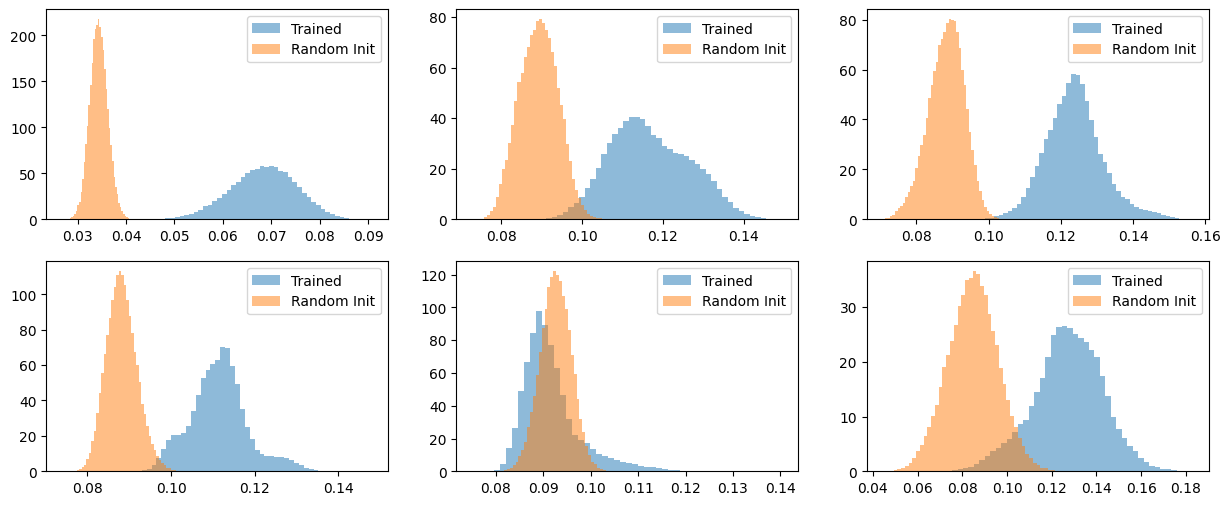

In [22]:
fig, axs = plt.subplots(2,3)
fig.set_size_inches(15,6)

axs[0,0].hist(cushion_list[0],density=True,bins=50,alpha=0.5, label='Trained')
axs[0,1].hist(cushion_list[1],density=True,bins=50,alpha=0.5, label='Trained')
axs[0,2].hist(cushion_list[2],density=True,bins=50,alpha=0.5, label='Trained')
axs[1,0].hist(cushion_list[3],density=True,bins=50,alpha=0.5, label='Trained')
axs[1,1].hist(cushion_list[4],density=True,bins=50,alpha=0.5, label='Trained')
axs[1,2].hist(cushion_list[5],density=True,bins=50,alpha=0.5, label='Trained')

axs[0,0].hist(init_cushion_list[0],density=True,bins=50,alpha=0.5, label='Random Init')
axs[0,1].hist(init_cushion_list[1],density=True,bins=50,alpha=0.5, label='Random Init')
axs[0,2].hist(init_cushion_list[2],density=True,bins=50,alpha=0.5, label='Random Init')
axs[1,0].hist(init_cushion_list[3],density=True,bins=50,alpha=0.5, label='Random Init')
axs[1,1].hist(init_cushion_list[4],density=True,bins=50,alpha=0.5, label='Random Init')
axs[1,2].hist(init_cushion_list[5],density=True,bins=50,alpha=0.5, label='Random Init')

for row in axs:
    for ax in row:
        ax.legend()

plt.savefig('plots/Fully_Connected_Cushions.png')

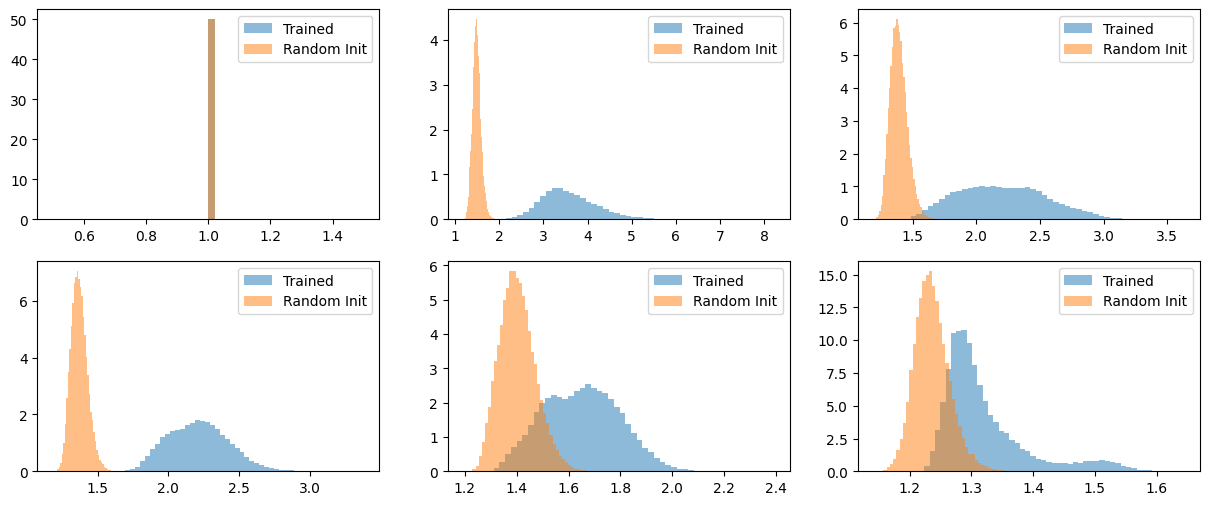

In [23]:
fig, axs = plt.subplots(2,3)
fig.set_size_inches(15,6)

axs[0,0].hist(activations[0],density=True,bins=50,alpha=0.5, label='Trained')
axs[0,1].hist(activations[1],density=True,bins=50,alpha=0.5, label='Trained')
axs[0,2].hist(activations[2],density=True,bins=50,alpha=0.5, label='Trained')
axs[1,0].hist(activations[3],density=True,bins=50,alpha=0.5, label='Trained')
axs[1,1].hist(activations[4],density=True,bins=50,alpha=0.5, label='Trained')
axs[1,2].hist(activations[5],density=True,bins=50,alpha=0.5, label='Trained')

axs[0,0].hist(init_activations[0],density=True,bins=50,alpha=0.5, label='Random Init')
axs[0,1].hist(init_activations[1],density=True,bins=50,alpha=0.5, label='Random Init')
axs[0,2].hist(init_activations[2],density=True,bins=50,alpha=0.5, label='Random Init')
axs[1,0].hist(init_activations[3],density=True,bins=50,alpha=0.5, label='Random Init')
axs[1,1].hist(init_activations[4],density=True,bins=50,alpha=0.5, label='Random Init')
axs[1,2].hist(init_activations[5],density=True,bins=50,alpha=0.5, label='Random Init')

for row in axs:
    for ax in row:
        ax.legend()

plt.savefig('plots/Fully_Connected_Activations.png')